In [66]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot
from filters import butter_lowpass
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import train_loop
from DE_Pytorch import DE
from scipy import signal
from scipy.stats import norm
from torchsummary import summary

In [68]:
def get_data(num_symbols, SNRdb, lowpass=None):
    
    symbol_set = [3, 1, -1, -3,] # all symbols that we use
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
    
    sigma = CS.SNRdb_to_sigma(SNRdb, 8, use_gain=False)
    print(sigma)

    gain_factor = np.max(np.convolve(CS.h, CS.h))
    upsampled = CS.upsample(v=False)
    Tx = np.convolve(upsampled, CS.h)
    
    if lowpass is not None:
        print('low')
        b, a = butter_lowpass(lowpass, CS.m, 10)
        Tx = signal.filtfilt(b, a, Tx)

    # Normalize signal
    Tx = Tx / np.sqrt(np.mean(np.square(Tx)))
    Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise
    
    X = torch.tensor(Tx)
    X = X.view(1, 1, -1).float() # reshape and cast to float so PyTorch understands it
    y = symbol_seq
    classes = np.array(symbol_set)
    num_classes = len(classes)

    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X, y

def make_net():
    net = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
    for param in net.parameters():
        param.requires_grad = False
    return net

In [126]:
# Create Data
Xtrain, ytrain = get_data(num_symbols=1000000, SNRdb=6.5, lowpass=None)
Xtest, ytest = get_data(num_symbols=1000000, SNRdb=6.5, lowpass=None)

# Create 1D Convolutional Neural Network with PyTorch and define optimizer and loss
NN = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NN.parameters(), lr=1e-2)

D = DE(objective_function=torch.nn.CrossEntropyLoss(), pop_size=400, population_function=make_net, 
       X=Xtrain, y=ytrain, Xtest=Xtest, ytest=ytest, F=0.6, cr=0.85, use_cuda=True)
#summary(make_net(), input_size=(1, 1, 8063))

1.3382738549544602
1.3382738549544602
Using GPU


In [ ]:
# DE Training

best_agent = D.evolution(num_epochs=3000, verbose=True, print_epoch=10, X=Xtrain, y=ytrain)
#best_agent, opt_agent = D.early_stop_training(patience=500, measure='accuracy')

D.evaluate()
acc = torch.sum(D.best_agent.to('cpu')(Xtest).argmax(axis=1) == ytest)/len(ytest)
print('Accuracy:', acc.item())
D.best_agent.to('cuda')

Using GPU
Epoch 0: 
 Train Loss: 1.4598668813705444 
 Test Loss: 1.4078552722930908


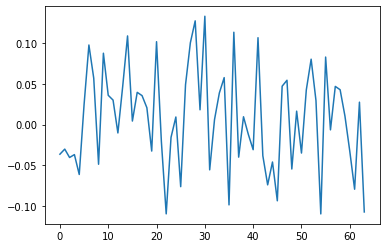

Epoch 100: 
 Train Loss: 0.6303408145904541 
 Test Loss: 0.6289012432098389


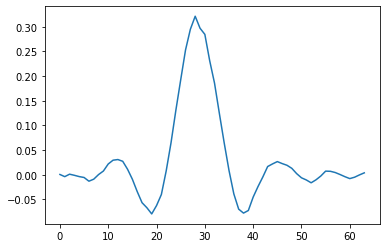

Epoch 200: 
 Train Loss: 0.5936657786369324 
 Test Loss: 0.5928453803062439


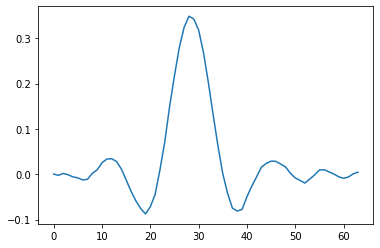

Epoch 300: 
 Train Loss: 0.5854894518852234 
 Test Loss: 0.5848127603530884


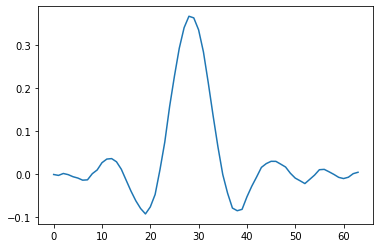

KeyboardInterrupt: 

In [127]:
# Backprop Training


#Xtrain, ytrain = get_data(num_symbols=1000, SNRdb=10, lowpass=None)
#Xtest, ytest = get_data(num_symbols=1000, SNRdb=10, lowpass=None)

testcosts, traincosts = train_loop(model=NN.to('cuda'), optimizer=optimizer, cost=criterion, Xtrain=Xtrain, ytrain=ytrain, 
                                   Xtest=Xtest, ytest=ytest, epochs=2000, eval=True, plot_iteration=100, 
                                   use_cuda=True)

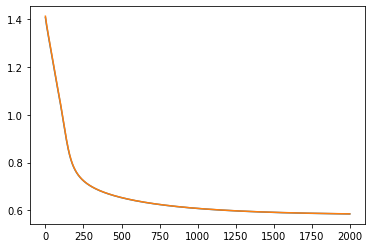

In [128]:
plt.plot(testcosts, label='test')
plt.plot(traincosts, label='train')
plt.show()

In [39]:
# Evaluate

#NN.to('cpu')
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 100000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
SNR = 16
# can never not normalize and not use gain. Either one or both.

euclid_decisions = CS.transmission(SNRdb=SNR, mode='euclidean')
receiver_net_decisions = CS.transmission(SNRdb=SNR, mode='network', rx_cutoff=None, model=best_agent, joint_cutoff=2)


print("Accuracy:", 1 - CS.evaluate(euclid_decisions)[1])
print("Accuracy:", 1 - CS.evaluate(receiver_net_decisions)[1])

Accuracy: 0.99638
Accuracy: 0.99589


In [133]:
SNRdbs, euclid_er, network_er, NN_er, block_er, joint_er,  error_theory = \
SNR_plot(num_symbols=300000, rx_model=NN)

Avg symbol energy 5.01448
gain 7.9976510763715565


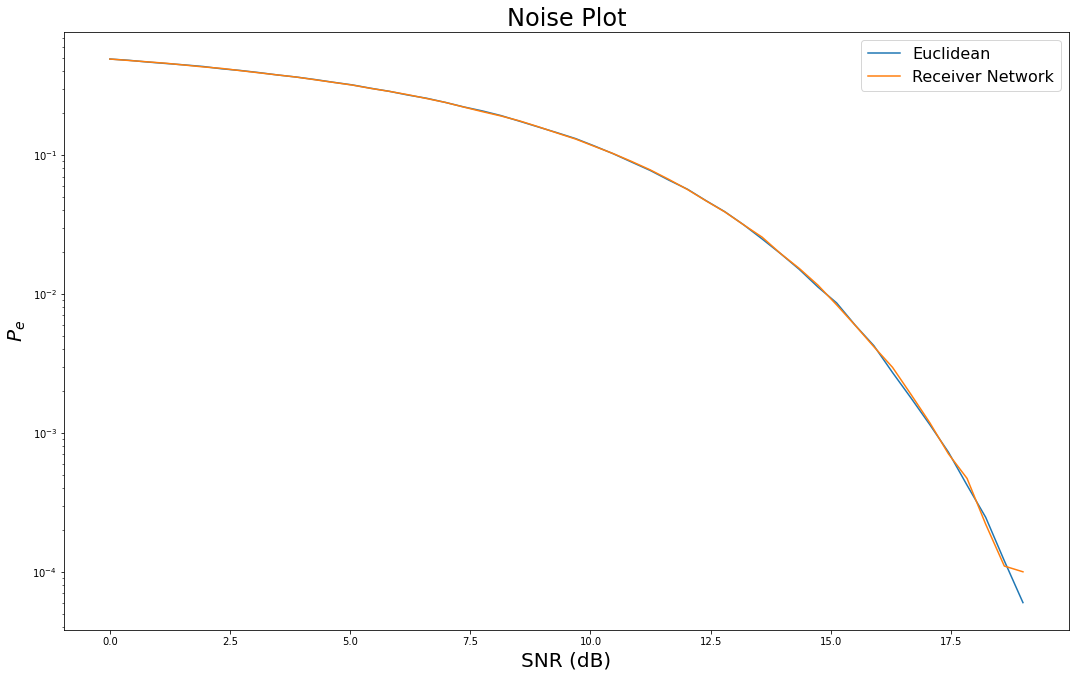

In [136]:
plt.figure(figsize=(18,11))
plt.title('Noise Plot', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
num = 0
plt.semilogy(SNRdbs[num:], euclid_er[num:], label='Euclidean')
#plt.semilogy(SNRdbs[num:], NN_er[num:])
#plt.semilogy(SNRdbs[num:], block_er[num:])
plt.semilogy(SNRdbs[num:], network_er[num:], label='Receiver Network')
#plt.semilogy(SNRdbs[num:], joint_er[num:], alpha=1)
#plt.semilogy(SNRdbs[num:], error_theory[num:], alpha=1, label='Theory')
plt.legend(fontsize=16)
plt.show()